## Earnings on Medium: a statistical analysis (or, how much I didn't earn with 200K+ views) (code)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pymc3 as pm
sns.set_style("whitegrid")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [5]:
df = pd.read_csv("medium_post_data.csv", skiprows=1).iloc[:, 1:-4]
df = df[~df.internal_views.isnull()]

In [6]:
h = df.member_reading_time.astype(str).str.split(".", expand=True)
h.loc[:, 0] = (h.loc[:, 0].astype(float) * 60)/60
h.loc[:, 1] = ("." + h.loc[:, 1]).astype(float)
h.loc[:, 1] = (h.loc[:, 1] * 100)/60
df["member_reading_time_adj"] = h.sum(1)

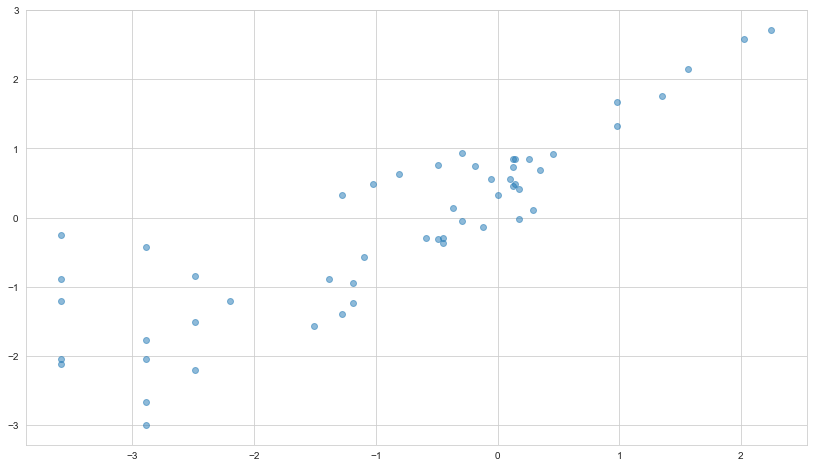

In [7]:
plt.figure(figsize=(14, 8))
plt.scatter(np.log(df.member_reading_time_adj), np.log(df.earnings), alpha=.5)

In [8]:
m = sm.OLS(endog=df.earnings, exog=sm.add_constant(df[["member_reading_time_adj"]])) 
fitted = m.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               earnings   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     1493.
Date:                Tue, 20 Apr 2021   Prob (F-statistic):           1.93e-39
Time:                        20:46:57   Log-Likelihood:                -41.093
No. Observations:                  53   AIC:                             86.19
Df Residuals:                      51   BIC:                             90.13
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.1066      0.087      1.225      0.226      -0.068       0.281
member_reading_time_adj     1.6286      0.042     38.641      0.000       1.544       1.713
==============================================================================
Omnibus:                        1.769   Durbin-Watson:                   1.437
Prob(Omnibus):                  0.413   Jarque-Bera (JB):                1.538
Skew:                           0.411   Prob(JB):                        0.463
Kurtosis:                       2.860   Cond. No.                         2.63
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

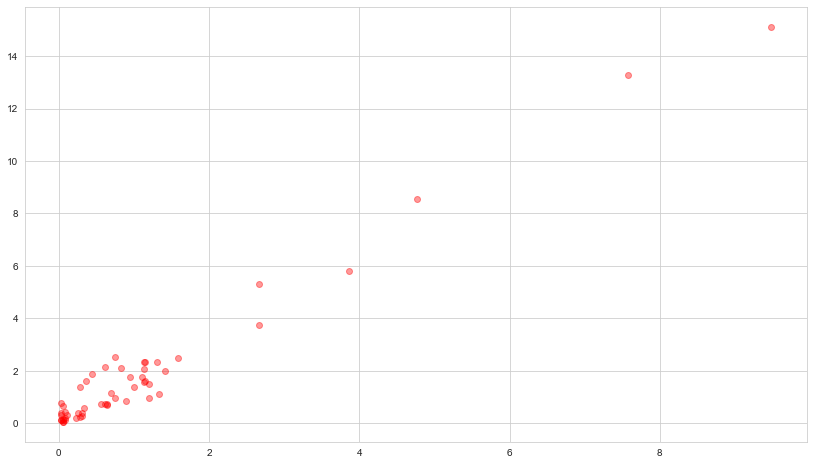

In [9]:
plt.figure(figsize=(14, 8))
plt.scatter(df.member_reading_time_adj, df.earnings, alpha=.4, color="red")

In [10]:
pd.to_datetime("2021-04-20")-pd.to_datetime("2017-11-27")

Timedelta('1240 days 00:00:00')

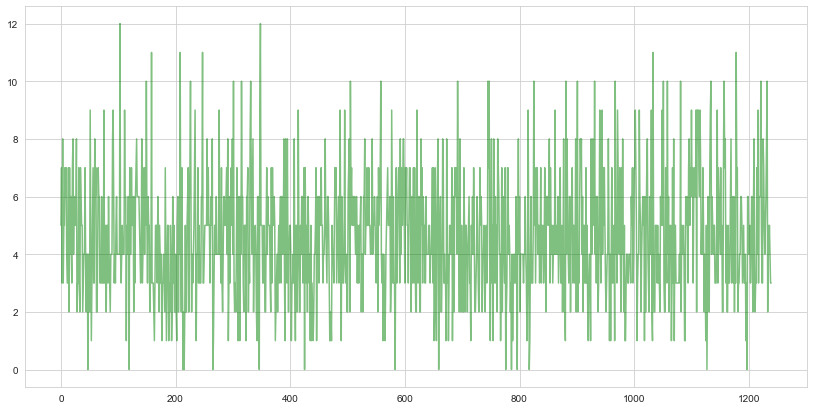

In [11]:
plt.figure(figsize=(14, 7))
np.random.seed(123)
x = np.clip(sm.add_constant(np.random.poisson(lam=4.61, size=1240)), 0, np.Inf)
plt.plot(x[:, 1], c="green", alpha=.5)

In [12]:
x[:, 1].sum()/60

94.98333333333333

In [13]:
fitted.predict(x).sum()

9413.598835905663

In [14]:
df["yhat"] = fitted.predict(sm.add_constant(df.member_reading_time))

In [15]:
df.assign(error = lambda x: x.earnings-x.yhat).error.mean()

0.2868672110146851

## Bayesian Model 

In [16]:
model = pm.Model()
with model:
    
    a = pm.Normal("a", 0, 1)
    b = pm.Normal("b", 0, 1)
    error = pm.HalfCauchy("error", 3)
    
    yhat = a + b * df.member_reading_time_adj

    lik = pm.Normal("lik", yhat, error, observed=df.earnings)

In [17]:
with model:
    trace = pm.sample(2000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [error, b, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


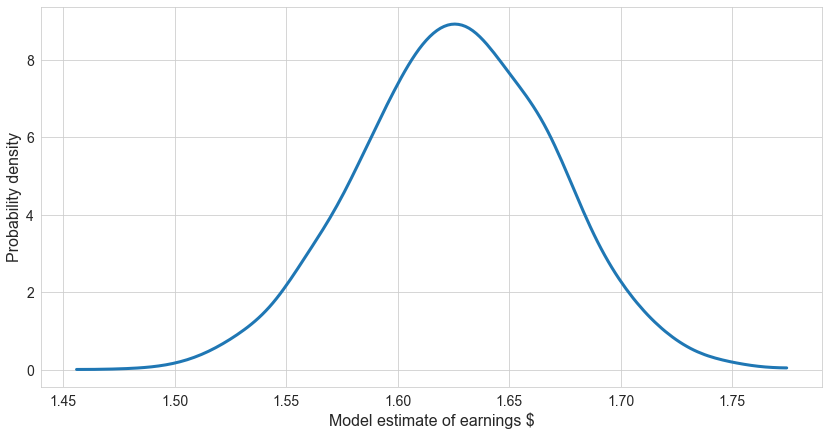

In [18]:
plt.figure(figsize=(14, 7))
pm.plot_dist(trace["b"])
plt.xlabel("Model estimate of earnings $", fontsize=16)
plt.ylabel("Probability density", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

/Users/conormcdonald/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


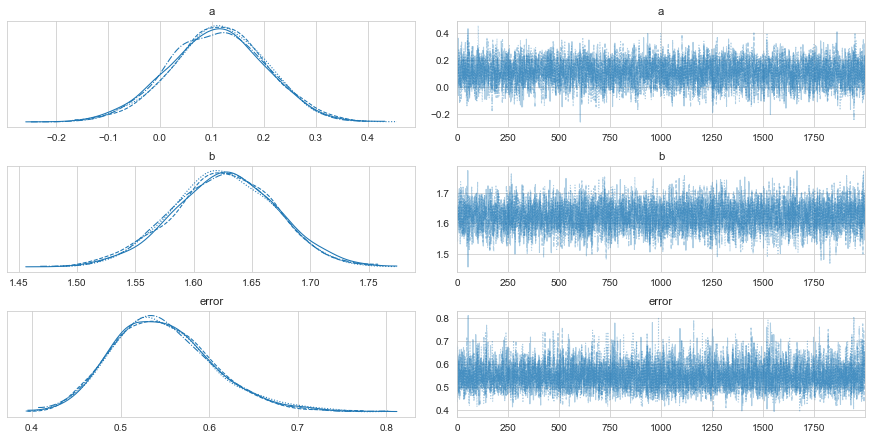

In [19]:
pm.traceplot(trace);

In [20]:
pm.summary(trace)

/Users/conormcdonald/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.110,0.091,-0.058,0.281,0.001,0.001,4949.0,4948.0,4947.0,5093.0,1.0
b,1.625,0.044,1.546,1.711,0.001,0.000,4885.0,4882.0,4883.0,5306.0,1.0
error,0.548,0.057,0.448,0.656,0.001,0.000,6841.0,6789.0,6756.0,4098.0,1.0


In [21]:
preds = pm.sample_posterior_predictive(trace, model=model, samples=2000)

/Users/conormcdonald/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1618: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


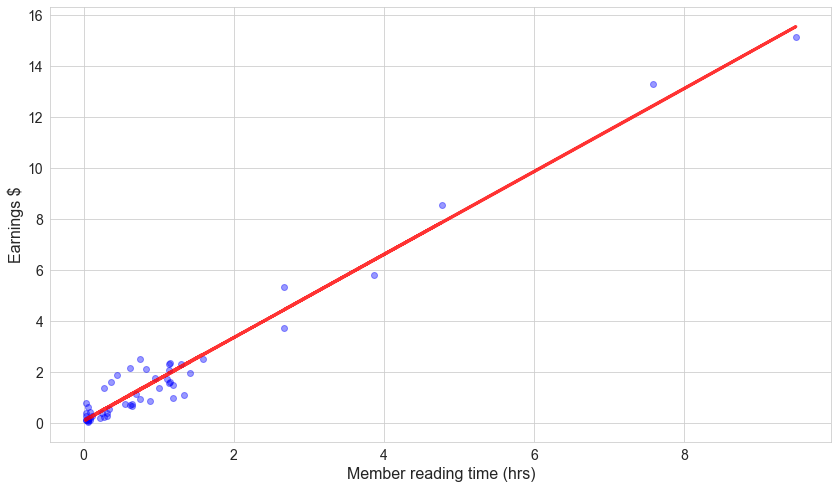

In [22]:
plt.figure(figsize=(14, 8))
plt.scatter(df.member_reading_time_adj, df.earnings, alpha=.4, color="blue")
plt.plot(df.member_reading_time_adj, pd.DataFrame(preds["lik"]).mean(), alpha=.8, color="red", linewidth=3)
plt.xlabel("Member reading time (hrs)", fontsize=16)
plt.ylabel("Earnings $", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [23]:
pm.trace_to_dataframe(trace)

,a,b,error
0,0.182382,1.633860,0.566820
1,0.188514,1.632685,0.485893
2,0.166639,1.592550,0.557141
3,-0.047831,1.658788,0.617431
4,-0.020909,1.636072,0.641434
...,...,...,...
7995,0.059730,1.590384,0.563427
7996,0.063354,1.593215,0.549593
7997,0.193952,1.635908,0.535670
7998,0.014315,1.622910,0.539492
